## Prepare dan Collect Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#untuk menghubungkan gdrive ke google colaboratory

import os
#os digunakan untuk berinteraksi dengan sistem operasi
import cv2
#cv2 (OpenCV) digunakan untuk memanipulasi gambar
import numpy as np
#numpy digunakan untuk operasi numerik
import math
#math digunakan untuk fungsi matematika
import matplotlib.pyplot as plt
#matplotlib.pyplot digunakan untuk visualisasi data

from sklearn.svm import LinearSVC
#LinearSVC adalah implementasi Support Vector Classifier pada scikit-learn

from sklearn.model_selection import train_test_split
#train_test_split digunakan untuk membagi data menjadi data pelatihan dan data pengujian.

#Mendefinisikan kelas dan label
classes = {
    'emas': 0,
    'perunggu': 1
}

# Mendefinisikan path dataset koin training
training_dataset_path = '/content/drive/MyDrive/pengolahan citra digital/fp/dataset/dataset/training'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-Process

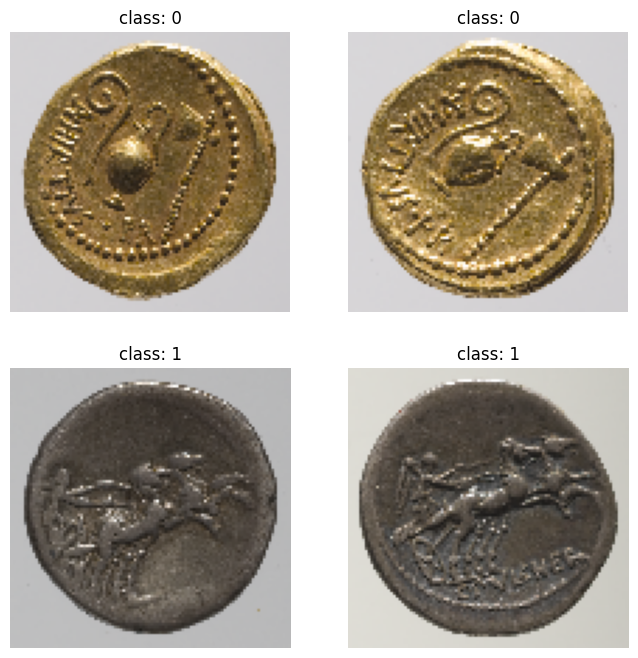

In [ ]:
# Fungsi untuk melakukan pre-process dengan metode resampling
def resample(image, new_size):
    #Fungsi resample digunakan untuk pre-processing pada gambar dengan metode resampling, ini menerima dua parameter, yaitu image dan new_size
    height, width = new_size
    # ada baris ke-3, new_size digunakan untuk mendapatkan tinggi(height) dan lebar(width) baru
    resized_image = cv2.resize(image, (width, height))
    # menggunakan fungsi cv2.resize diubah ukurannya menjadi new_size
    return resized_image
    # Gambar hasil resampling (resized_image) kemudian dikembalikan.


# Fungsi untuk membaca dataset koin training dan melakukan pre-process
def preprocess_dataset(dataset_path, classes, new_size):
    images = []  # List untuk menyimpan gambar-gambar
    labels = []  # List untuk menyimpan label-label

    for class_name, class_label in classes.items():  # Loop untuk setiap kelas dalam kamus classes
        class_path = os.path.join(dataset_path, class_name)  # Path lengkap ke folder kelas
        for image_name in os.listdir(class_path):  # Loop untuk setiap gambar dalam folder kelas
            image_path = os.path.join(class_path, image_name)  # Path lengkap ke gambar
            image = cv2.imread(image_path)  # Membaca gambar
            if image is not None:  # Memastikan gambar berhasil dibaca
                resized_image = resample(image, new_size)  # Resampling gambar
                images.append(resized_image)  # Menambahkan gambar yang sudah diresample ke list images
                labels.append(class_label)  # Menambahkan label kelas ke list labels

    return images, labels  # Mengembalikan images dan labels sebagai output fungsi


# Lakukan pre-process terhadap dataset koin training
new_size = (100, 100)  # Mendefinisikan ukuran baru untuk resampling
# ukuran (100, 100) mungkin dipilih sebagai ukuran yang memadai untuk mempertahankan informasi kunci
# pada gambar koin dalam dataset, sambil tetap mempertahankan efisiensi pemrosesan.

images, labels = preprocess_dataset(training_dataset_path, classes, new_size)  # Melakukan pre-process terhadap dataset koin training


# Tampilkan contoh gambar setelah resampling
plt.figure(figsize=(8, 8))  # Membuat figure plot dengan ukuran 8x8
for i in range(4):  # Loop untuk 4 gambar pertama
    plt.subplot(2, 2, i + 1)  # Membuat subplot dalam grid 2x2
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Menampilkan gambar dengan konversi warna dari BGR ke RGB
    plt.title('class: ' + str(labels[i]))  # Menampilkan judul gambar dengan label kelas
    plt.axis('off')  # Menghilangkan sumbu koordinat pada gambar

plt.show()  # Menampilkan plot gambar


## Segmentation

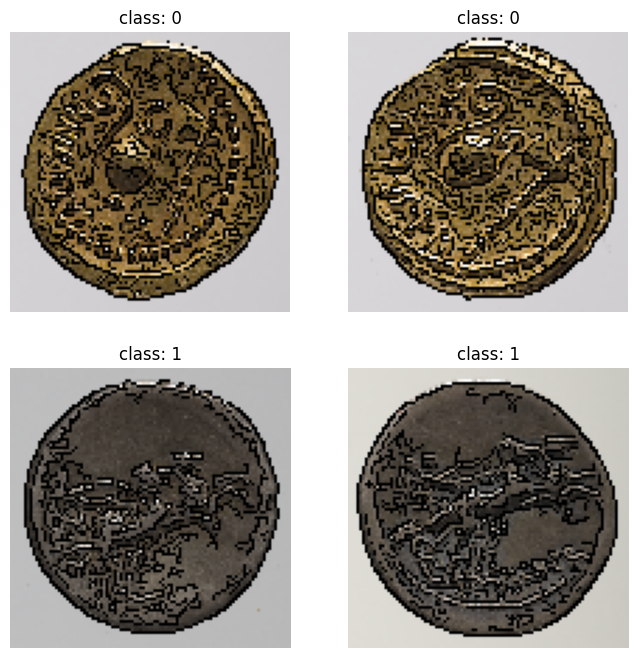

In [ ]:
# Fungsi untuk melakukan segmentasi dengan metode Canny Edge Detection dan menimpa garis tepi di atas gambar asli
def segment_canny(image):
    edges = cv2.Canny(image, 50, 150)  # Menggunakan metode Canny Edge Detection dengan threshold 50 dan 150
    segmented_image = np.copy(image)  # Membuat salinan gambar asli
    segmented_image[edges != 0] = (0, 0, 0)  # Mengganti warna garis tepi menjadi hitam
    return segmented_image

# Fungsi untuk melakukan segmentasi pada dataset koin training
def segment_dataset(images):
    segmented_images = []  # List untuk menyimpan gambar-gambar hasil segmentasi
    for image in images:  # Loop untuk setiap gambar dalam dataset
        segmented_image = segment_canny(image)  # Melakukan segmentasi pada gambar menggunakan fungsi segment_canny
        segmented_images.append(segmented_image)  # Menambahkan gambar hasil segmentasi ke list segmented_images
    return segmented_images

# Lakukan segmentasi pada dataset koin training
segmented_images = segment_dataset(images)

# Tampilkan contoh gambar hasil segmentasi
plt.figure(figsize=(8, 8))  # Membuat figure plot dengan ukuran 8x8

for i in range(4):  # Loop untuk 4 gambar pertama
    plt.subplot(2, 2, i + 1)  # Membuat subplot dalam grid 2x2
    plt.imshow(cv2.cvtColor(segmented_images[i], cv2.COLOR_BGR2RGB))  # Menampilkan gambar hasil segmentasi dengan konversi warna dari BGR ke RGB
    plt.title('class: ' + str(labels[i]))  # Menampilkan judul gambar dengan label kelas
    plt.axis('off')  # Menghilangkan sumbu koordinat pada gambar

plt.show()  # Menampilkan plot gambar


## Augmentation

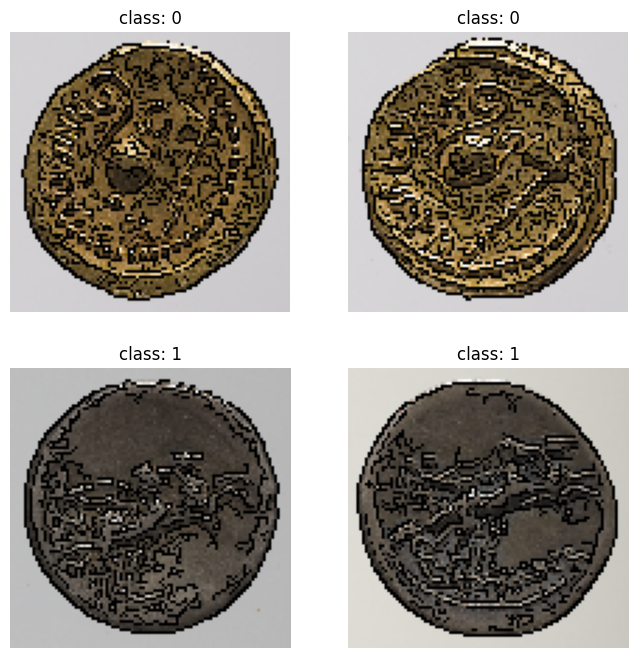

In [ ]:
# Fungsi untuk melakukan augmentasi dengan metode Gaussian
def augment_gaussian(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)  # Membuat noise dengan distribusi Gaussian
    augmented_image = np.clip(image + noise, 0, 255).astype(np.uint8)  # Menambahkan noise pada gambar dengan batasan nilai piksel 0-255
    return augmented_image

# Fungsi untuk melakukan augmentasi pada dataset koin training
def augment_dataset(images):
    augmented_images = []  # List untuk menyimpan gambar-gambar hasil augmentasi
    for image in images:  # Loop untuk setiap gambar dalam dataset
        augmented_image = augment_gaussian(image)  # Melakukan augmentasi pada gambar menggunakan fungsi augment_gaussian
        augmented_images.append(augmented_image)  # Menambahkan gambar hasil augmentasi ke list augmented_images
    return augmented_images


# Lakukan augmentasi pada dataset koin training
augmented_images = augment_dataset(segmented_images)  # Lakukan augmentasi pada dataset koin training


# Tampilkan contoh gambar hasil augmentasi
plt.figure(figsize=(8, 8))  # Membuat figure plot dengan ukuran 8x8
for i in range(4):  # Loop untuk 4 gambar pertama
    plt.subplot(2, 2, i + 1)  # Membuat subplot dalam grid 2x2
    plt.imshow(cv2.cvtColor(augmented_images[i], cv2.COLOR_BGR2RGB))  # Menampilkan gambar hasil augmentasi dengan konversi warna dari BGR ke RGB
    plt.title('class: ' + str(labels[i]))  # Menampilkan judul gambar dengan label kelas
    plt.axis('off')  # Menghilangkan sumbu koordinat pada gambar

plt.show()  # Menampilkan plot gambar


## Feature Extration

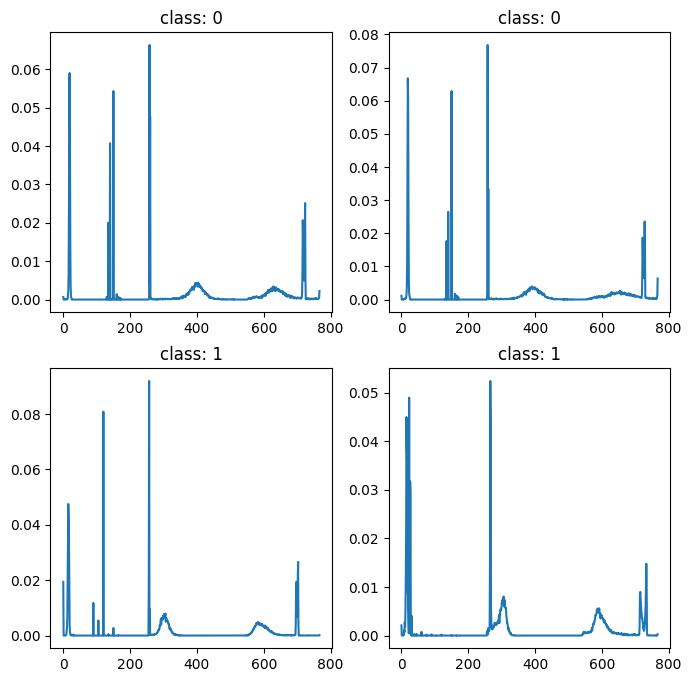

In [ ]:
# Fungsi untuk melakukan ekstraksi fitur dengan metode HSV
def extract_features_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Konversi gambar ke ruang warna HSV
    hue_histogram = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])  # Menghitung histogram Hue
    saturation_histogram = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])  # Menghitung histogram Saturation
    value_histogram = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])  # Menghitung histogram Value
    features = np.concatenate((hue_histogram, saturation_histogram, value_histogram), axis=None)  # Menggabungkan histogram menjadi satu fitur
    features /= np.sum(features)  # Normalisasi fitur
    return features

# Fungsi untuk melakukan ekstraksi fitur pada dataset koin training
def extract_features_dataset(images):
    features = []  # List untuk menyimpan fitur-fitur hasil ekstraksi
    for image in images:  # Loop untuk setiap gambar dalam dataset
        extracted_features = extract_features_hsv(image)  # Melakukan ekstraksi fitur pada gambar menggunakan fungsi extract_features_hsv
        features.append(extracted_features)  # Menambahkan fitur hasil ekstraksi ke list features
    return features


# Lakukan ekstraksi fitur pada dataset koin training
extracted_features = extract_features_dataset(images)

# Tampilkan contoh hasil ekstraksi fitur
plt.figure(figsize=(8, 8))  # Membuat gambar (figure) dengan ukuran 8x8

for i in range(4):  # Melakukan iterasi sebanyak 4 kali
    plt.subplot(2, 2, i + 1)  # Membuat subplot 2x2 dengan nomor subplot sesuai dengan iterasi
    plt.plot(extracted_features[i])  # Memplot grafik garis menggunakan fitur yang diekstraksi
    plt.title('class: ' + str(labels[i]))  # Memberikan judul subplot dengan label yang dikonversi menjadi string
plt.show()  # Menampilkan gambar


## Training

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


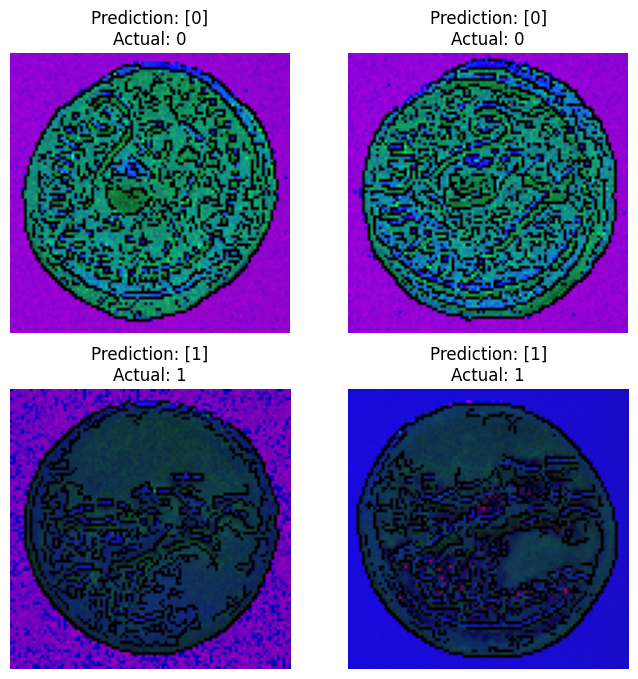

Akurasi klasifikasi dengan metode SVM: 1.0


In [ ]:
# Fungsi untuk melakukan klasifikasi dengan metode SVM
def classify_svm(features, labels):
    # Membagi dataset menjadi data latih dan data uji menggunakan train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    # Membuat objek model SVM dengan LinearSVC()
    svm_model = LinearSVC()
    # Melatih model SVM dengan data latih menggunakan metode fit()
    svm_model.fit(X_train, y_train)
    # Memprediksi label untuk data uji menggunakan model yang telah dilatih
    y_pred = svm_model.predict(X_test)
    # Menghitung akurasi klasifikasi dengan membandingkan label prediksi (y_pred) dengan label sebenarnya (y_test)
    accuracy = (y_pred == y_test).mean()
    # Mengembalikan model SVM yang telah dilatih dan akurasi klasifikasi
    return svm_model, accuracy


# Fungsi untuk melakukan ekstraksi fitur menggunakan metode HSV
def extract_features(images):
    # Inisialisasi list features dan processed_images
    features = []
    processed_images = []
    # Loop melalui setiap gambar dalam list images
    for image in images:
        # Konversi gambar dari ruang warna BGR ke HSV menggunakan cv2.cvtColor()
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # Ekstraksi fitur menggunakan komponen warna H, S, dan V
        h, s, v = cv2.split(hsv_image)
        # Ekstraksi fitur dilakukan dengan menghitung rata-rata (mean) dari komponen H, S, dan V
        feature = [np.mean(h), np.mean(s), np.mean(v)]
        # Menambahkan fitur ke dalam list features
        features.append(feature)
        # Menyimpan gambar yang telah diproses (hsv_image) ke dalam list processed_images
        processed_images.append(hsv_image)
    # Mengubah list features dan processed_images menjadi array numpy menggunakan np.array()
    return np.array(features), np.array(processed_images)



# Lakukan pre-process terhadap dataset koin training
images, labels = preprocess_dataset(training_dataset_path, classes, new_size) # Lakukan segmentasi terhadap dataset pre-process
segmented = segment_dataset(images) # Lakukan segmentasi terhadap dataset pre-process
augmented = augment_dataset(segmented) # Lakukan ekstraksi fitur menggunakan metode HSV
extracted_features, processed_images = extract_features(augmented) # Lakukan klasifikasi dengan metode SVM pada dataset koin training
svm_model, accuracy = classify_svm(extracted_features, labels) # Tampilkan contoh gambar hasil klasifikasi

plt.figure(figsize=(8, 8))  # Membuat gambar baru dengan ukuran 8x8 inci
for i in range(4):  # Loop melalui 4 gambar untuk ditampilkan
    plt.subplot(2, 2, i + 1)  # Membuat subplot dengan 2 baris dan 2 kolom, dan memilih subplot ke-i+1
    plt.imshow((processed_images[i]))  # Menampilkan gambar yang telah diproses
    plt.title('Prediction: ' + str(svm_model.predict([extracted_features[i]])) + '\nActual: ' + str(labels[i]))  # Menambahkan judul subplot dengan prediksi dan label aktual
    plt.axis('off')  # Menyembunyikan sumbu x dan y pada gambar
plt.show()  # Menampilkan gambar dengan subplot yang telah dibuat


# Tampilkan akurasi klasifikasi
print("Akurasi klasifikasi dengan metode SVM:", accuracy)


## Testing

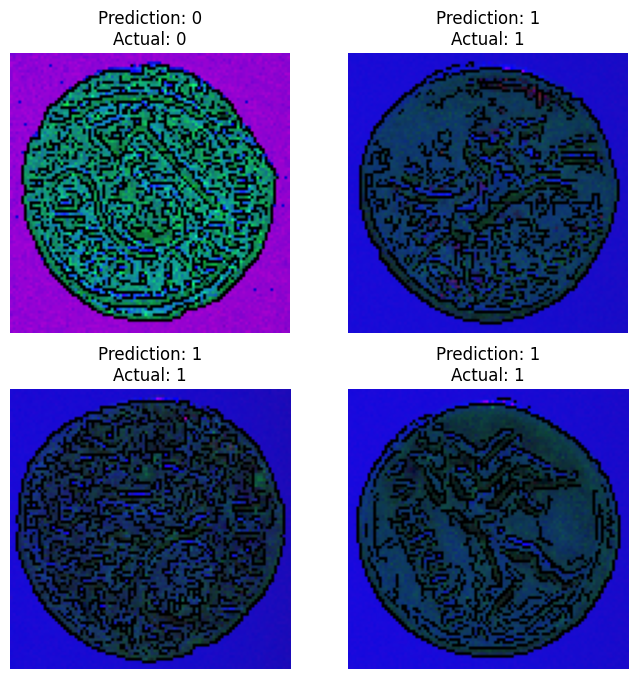

Akurasi pengujian dengan metode SVM: 1.0
Persentase data pelatihan: 67.03%
Persentase data pengujian: 32.97%


In [ ]:
# Mendefinisikan path dataset koin testing
testing_dataset_path = '/content/drive/MyDrive/pengolahan citra digital/fp/dataset/dataset/testing'

# Fungsi untuk menghitung persentase data pelatihan dan pengujian
def calculate_split_percentage(train_data, test_data):
    # Menghitung total data dari data pelatihan dan data pengujian
    total_data = len(train_data) + len(test_data)
    # Menghitung persentase data pelatihan dan data pengujian
    train_percentage = (len(train_data) / total_data) * 100
    test_percentage = (len(test_data) / total_data) * 100
    # Mengembalikan persentase data pelatihan dan data pengujian
    return train_percentage, test_percentage

# Fungsi untuk melakukan pengujian pada dataset koin testing
def test_dataset(testing_dataset_path, training_dataset_path, classes, new_size, svm_model):
    # Memproses dataset koin testing
    test_images, test_labels = preprocess_dataset(testing_dataset_path, classes, new_size)
    # Memproses dataset koin training
    train_images, train_labels = preprocess_dataset(training_dataset_path, classes, new_size)
    # Melakukan segmentasi pada dataset koin testing
    test_segment = segment_dataset(test_images)
    # Melakukan augmentasi pada dataset koin testing
    test_augment = augment_dataset(test_segment)
    # Melakukan ekstraksi fitur pada dataset koin testing
    test_features, test_processed = extract_features(test_augment)
    # Memprediksi label untuk data testing menggunakan model SVM yang telah dilatih sebelumnya
    predicted_labels = svm_model.predict(test_features)
    # Menghitung akurasi pengujian dengan membandingkan prediksi dengan label aktual
    accuracy = (predicted_labels == test_labels).mean()
    # Menghitung persentase data pelatihan dan pengujian
    train_percentage, test_percentage = calculate_split_percentage(train_images, test_images)




    # Menampilkan hasil pengujian
    # Menampilkan gambar dengan ukuran 8x8 inci
    plt.figure(figsize=(8, 8))

    # Melakukan iterasi sebanyak 4 kali
    for i in range(4):
        # Membuat subplot dengan ukuran 2x2
        plt.subplot(2, 2, i + 1) # Menampilkan gambar hasil pre-processing dari dataset koin testing pada subplot yang sedang aktif
        plt.imshow(test_processed[i]) # Mengatur judul pada subplot yang sedang aktif. Judul terdiri dari prediksi (predicted_labels) dan label aktual (test_labels) dari dataset koin testing.
        plt.title('Prediction: ' + str(predicted_labels[i]) + '\nActual: ' + str(test_labels[i])) # Menghilangkan sumbu (axis) pada subplot yang sedang aktif.
        plt.axis('off') # Menyembunyikan sumbu x dan y pada gambar

    # Menampilkan gambar-gambar hasil pengujian pada dataset koin testing.
    plt.show()


    print("Akurasi pengujian dengan metode SVM:", accuracy)
    # Menampilkan hasil persentase
    print("Persentase data pelatihan: {:.2f}%".format(train_percentage))
    print("Persentase data pengujian: {:.2f}%".format(test_percentage))

# Lakukan pengujian pada dataset koin testing
test_dataset(testing_dataset_path, training_dataset_path, classes, new_size, svm_model)